In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

# sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [4]:
dataset_settings = read_csv(DATASET_SETTINGS_CSV, header=0, index_col=0)
dataset_settings

,classes,network_model,stain,margins_um,num_sample_per_class,stacks,cell_features_used,comment,raw_image_dataset,win_id
dataset_id,,,,,,,,,,
20,NaN,Inception-BN,nissl,200/500,1000,MD585,NaN,NaN,NaN,NaN
21,NaN,Inception-BN,nissl,200/500,1000,MD589,NaN,NaN,NaN,NaN
22,NaN,Inception-BN,nissl,200/500,1000,MD594,NaN,NaN,NaN,NaN
23,pos/surPos/surNoclass/neg,inception-bn-blue,nissl,500,1000,MD585,NaN,NaN,NaN,NaN
24,pos/surPos/surNoclass/neg,inception-bn-blue,nissl,500,1000,MD589,NaN,NaN,NaN,NaN
25,pos/surPos/surNoclass/neg,inception-bn-blue,nissl,500,1000,MD594,NaN,NaN,NaN,NaN
26,NaN,inception-bn-blue,nissl,NaN,1000,MD594/MD589/MD585,NaN,far negatives for Pn,NaN,NaN
27,NaN,inception-bn-blue,nissl,NaN,1000,MD585,NaN,far negatives for all structures,NaN,NaN
28,NaN,inception-bn-blue,nissl,NaN,1000,MD589,NaN,far negatives for all structures,NaN,NaN


In [5]:
classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)
classifier_settings

,model,margin_um,train_set_id,neg_composition,sample_weighting,input_img_version,svm_id,comment,num_samples_per_class
classifier_id,,,,,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN,cropped_gray,30,NaN,NaN
31,lr,500,21/22,neg_has_all_surround,NaN,cropped_gray,31,NaN,NaN
32,lr,500,20/22,neg_has_all_surround,NaN,cropped_gray,32,NaN,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN,cropped_gray,33,NaN,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN,cropped_gray,34,NaN,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN,cropped_gray,35,NaN,NaN
36,gb1,500,23/24,neg_has_all_surround,NaN,cropped_gray,36,NaN,NaN
37,lr,500,23/24,neg_has_all_surround,NaN,cropped_gray,37,NaN,NaN
38,lr,500,23/24/27/28,neg_has_surround_and_negative,NaN,cropped_gray,38,NaN,NaN


In [6]:
classifier_id = 120

In [7]:
classifier_properties = classifier_settings.loc[classifier_id]

margin_um = classifier_properties['margin_um']
feature_classifier_model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']
svm_id = int(classifier_properties['svm_id'])
if not np.isnan(classifier_properties['num_samples_per_class']):
    num_samples_per_class = int(classifier_properties['num_samples_per_class'])
else:
    num_samples_per_class = None

In [8]:
from data_manager import *
from sklearn.mixture import GaussianMixture

In [9]:
lores_um = 25
lores_sigma = lores_um / XY_PIXEL_DISTANCE_LOSSLESS / 2

In [9]:
# structure = '7N'

# gm = GaussianMixture(n_components=3, covariance_type='full', tol=0.001, 
#                 reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', 
#                 weights_init=None, means_init=None, precisions_init=None, random_state=None, 
#                 warm_start=False, verbose=0, verbose_interval=10)

# gm.fit(lores_imgs.reshape((lores_imgs.size, 1)))

# display_images_in_grids(imgs[:10], nc=5, cmap=plt.cm.gray)
# display_images_in_grids(lores_imgs[:10], nc=5, cmap=plt.cm.gray)

# print gm.means_.flatten()
# print gm.covariances_.flatten()
# print gm.weights_.flatten()

# plt.plot([gm.score_samples(x) for x in range(0,256)]);

In [10]:
from skimage.feature import local_binary_pattern

In [11]:
feature_classifier_model = 'lin_svc'

In [ ]:
# for structure in all_known_structures:
for structure in ['12N']:
# for structure in ['5N',
#  '6N',
#  '7N',
#  '7n',
#  'Amb',
#  'LC',
#  'LRt',
#  'Pn',
#  'Tz',
#  'VLL',
#  'RMC',
#  'SNC',
#  'SNR',
#  '3N',
#  '4N',
#  'Sp5I',
#  'Sp5O',
#  'Sp5C',
#  'PBG',
#  '10N',
#  'VCA',
#  'VCP',
#  'DC',
#  'AP',
#  '12N',
#  'RtTg',
#  'SC',
#  'IC']:

    # Determine which labels to load.

    structures_to_sample = [structure]
    # structures_to_sample = all_known_structures
    # structures_to_sample = ['Pn']

    negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

    margins_to_sample = [margin_um]
    surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                                 for m in margins_to_sample
                                 for s in structures_to_sample 
                                 for surr_l in all_known_structures
                                 if surr_l != s]
    surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                                 for m in margins_to_sample
                                 for s in structures_to_sample]

    if neg_composition == 'neg_has_everything_else':
        labels_to_sample = structures_to_sample + negative_labels_to_sample
    elif neg_composition == 'neg_has_only_surround_noclass':
        labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
    elif neg_composition == 'neg_has_all_surround':
        labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']
    elif neg_composition == 'neg_has_surround_and_negative':
        labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample
    else:
        raise Exception("neg_composition %s not recognized" % neg_composition)

    ######################

    training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
#     training_features, training_addresses = DataManager.load_datasets_bp(training_set_ids, labels_to_sample=labels_to_sample)
    
    # Use other texture descriptors.
    training_features = defaultdict(list)
    for training_set in training_set_ids:
        for label in labels_to_sample:
            try:
                imgs = DataManager.load_dataset_patches(dataset_id=training_set, structure=label)
#                 lores_imgs = np.array([img_as_ubyte(gaussian(im, sigma=lores_sigma)) for im in imgs])

#                 # Form feature vector using mean intensities
#                 feats = np.array([[np.mean(img)] for img in imgs])

                # Form feature vector using mean intensities
                focal_size_um = 25
                focal_size = area_size_um / XY
                feats = np.array([[np.mean(img[img.shape[0]/2-focal_size:img.shape[0]/2+focal_size, 
                                               img.shape[1]/2-focal_size:img.shape[0]/2+focal_size])] 
                                  for img in imgs])

                # Form feature vector using all pixel intensities
#                 feats = lores_imgs.reshape((lores_imgs.size, 1))  

                # Feature vector is only the center pixel intensity
#                 feats = np.array([[img[img.shape[0]/2, img.shape[1]/2]] for img in lores_imgs]) 

                # Feature vector is the GLCM over lo-res patches
#                 glcm_levels = 10
#                 feats = np.array([get_glcm_feature_vector(img/int(np.ceil(256./glcm_levels)), levels=glcm_levels) 
#                                   for img in lores_imgs])

                # Feature vector is the GLCM over high-res patches
#                 glcm_levels = 10
#                 feats = np.array([get_glcm_feature_vector(img/int(np.ceil(256./glcm_levels)), levels=glcm_levels) 
#                                   for img in imgs])

#                 # LBP
#                 radius = 3
#                 n_points = 8 * radius
#                 lbps = [local_binary_pattern(img, P=n_points, R=radius, method='uniform') for img in imgs]
#                 feats = np.array([np.histogram(lbp, bins=int(lbp.max()+1), normed=True)[0] for lbp in lbps])
                ###############################################
                training_features[label].append(feats)
            except:
                pass
    training_features = {label: np.concatenate(feature_list) 
                         for label, feature_list in training_features.iteritems()}
    
    ########################

    labels_found = training_features.keys()
    structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

    ######################

    print structure

    #############################
    ## Define Positive Samples ##
    #############################

    features_pos = training_features[structure]

    if num_samples_per_class is not None:
        features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(num_samples_per_class, len(features_pos)),))]    

    n_pos = len(features_pos)
    print n_pos, 'positive examples'

    #############################
    ## Define Negative Samples ##
    #############################

    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
        for surr_s in all_known_structures:
            c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    elif neg_composition == 'neg_has_surround_and_negative':
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
        for surr_s in all_known_structures:
            c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
        neg_classes += [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])

    if num_samples_per_class is not None:
        features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(num_samples_per_class, len(features_neg)),))]

    n_neg = len(features_neg)
    print n_neg, 'negative examples'

    ###########################
    ## Define Sample Weights ##
    ###########################

    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])

        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None

    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]

    #     n_train = len(train_labels0)
    #     ri = np.random.choice(range(n_train), size=100, replace=False)
    #     train_data = train_data0[ri]
    #     train_labels = train_labels0[ri]

    #####################################
    ## Define feature_classifier_model ##
    #####################################

    if feature_classifier_model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)

    elif feature_classifier_model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)


    elif feature_classifier_model == 'lin_svc_calib':

        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)


    elif feature_classifier_model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

    elif feature_classifier_model == 'xgb2':
        clf = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=100, 
                            silent=False, objective='binary:logistic')
        # 40s, 10,000 pos and 10,000 neg samples

    elif feature_classifier_model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')

    elif feature_classifier_model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')


    else:
        sys.stderr.write('Setting is not recognized.\n')

    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

#     clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
#     create_parent_dir_if_not_exists(clf_fp)
#     joblib.dump(clf, clf_fp)
#     upload_to_s3(clf_fp)

    from sklearn.metrics import accuracy_score
    train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
    print train_acc

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_5N.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_5N.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_5N.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_6N.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_6N.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_6N.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_7N.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/dat

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_VCP.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_VCP.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_VCP.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_DC.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_DC.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_DC.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_75/patch_images_12N_surround_500_RtTg.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifier

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_4N.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_4N.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_4N.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_Sp5I.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_Sp5I.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_Sp5I.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_76/patch_images_12N_surround_500_Sp5O.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classif

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_Tz.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_Tz.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_Tz.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_VLL.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_VLL.hdf" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_VLL.hdf"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_77/patch_images_12N_surround_500_RMC.hdf" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers

In [15]:
joblib.dump(clf, '/tmp/12N_gray_clf.clf')

['/tmp/12N_gray_clf.clf']

In [ ]:
# RESULTS:

# 5N training acc using mean smoothed greylevel intensity = 0.637
# 5N training acc using vector of smoothed greylevel intensity = 0.611
# 5N training acc using center smoothed greylevel intensity = 0.606
# 5N training acc using lo-res glcm = 0.63
# 5N training acc using hi-res glcm = 0.784
# 5N training acc using uniform lbp = 0.71 (radius have no influence)
# 5N training acc using CNN feature = 0.93

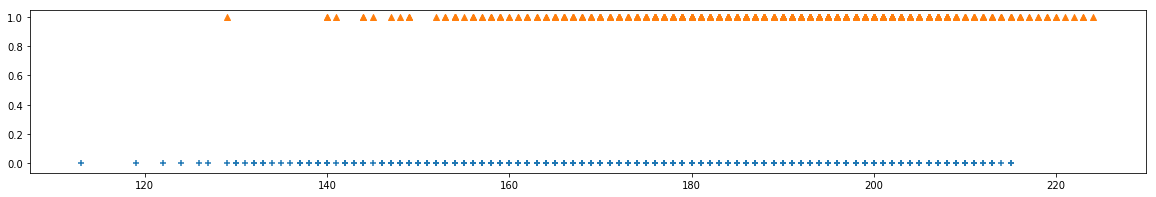

In [112]:
plt.figure(figsize=(20,3));
plt.scatter(features_pos.flatten(), np.zeros((features_pos.size,)), marker='+')
plt.scatter(features_neg.flatten(), np.ones((features_neg.size,)), marker='^')